In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt  #Graphics
from sklearn.ensemble import RandomForestClassifier  #Random Forest algorithm
from sklearn.ensemble import RandomForestRegressor  #Random Forest algorithm
from sklearn.model_selection import train_test_split

### Load the data

Load the MNIST data set from two `.csv` files into two variables. 
Print the number of data points in the training and test sets.
Print the number of object in eacsh class.

In [2]:
train = pd.read_csv("data/mnist_train.csv")
test = pd.read_csv("data/mnist_test.csv")
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))
print ("Testing dataset has %i observations and %i variables" %(test.shape[0], test.shape[1]))
#Seperate the target and independant variables
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]
#Check the frequency of each number
df_y.value_counts().sort_index()

Training dataset has 59999 observations and 785 variables
Testing dataset has 9999 observations and 785 variables


0    5923
1    6742
2    5958
3    6131
4    5842
5    5420
6    5918
7    6265
8    5851
9    5949
Name: 5, dtype: int64

### Slipt the data

Split the training and test data into two equal parts. In total, we obtain four data sets, 
1. ${\cal D}_{train}$ to train the classifier,
2. ${\cal D}_{val}$ to train the localization function, 
3. ${\cal D}_{cal}$ to compute the quantiles,
4. ${\cal D}_{test}$ to evaluate the predictions sets.

In [3]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
#Split the train dataset and reduce dimensions
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]
d = 100
pca = PCA(n_components = d)
pca.fit(df_x.to_numpy(dtype=float))
xPca = pca.transform(df_x.to_numpy(dtype=float))
X_train, X_val, y_train, y_val = train_test_split(xPca, df_y.to_numpy(dtype=int), test_size=0.5, random_state=0)


#Split the train dataset
df_x=test.iloc[:,1:]
df_y=test.iloc[:,0]
xPca = pca.transform(df_x.to_numpy(dtype=float))
X_cal, X_test, y_cal, y_test = train_test_split(xPca, df_y.to_numpy(dtype=int), test_size=0.5, random_state=0)
print("train:", X_train.shape)
print("test:", X_test.shape)

train: (29999, 100)
test: (5000, 100)


### Train the classifier

Train a Random Forest classifier on ${\cal D}_{train}$.

In [4]:
#training the classifier #
K = 10
rf = KNeighborsClassifier(n_neighbors=K)
#rf = RandomForestClassifier(n_estimators=100) 
rf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

### Evaluate the classifier 

Print the error rate of the classifier on each data set.

In [5]:
probsTrain = rf.predict_proba(X_train)
ERtrain = 1 - sum([1 * (y_train[i] == np.argmax(probsTrain[i])) for i in range(len(probsTrain))])/len(probsTrain)
print("ERtrain =", ERtrain)
probsVal = rf.predict_proba(X_val)
ERval = 1 - sum([1 * (y_val[i] == np.argmax(probsVal[i])) for i in range(len(probsVal))])/len(probsVal)
print("ERval =", ERval)
probsTest = rf.predict_proba(X_test)
ERtest = 1 - sum([1 * (y_test[i] == np.argmax(probsTest[i])) for i in range(len(probsTest))])/len(probsTest)
print("ERtest =", ERtest)

probsTest = rf.predict_proba(X_test)
ERtest = 1 - sum([1 * (y_test[i] == np.argmax(probsTest[i])) for i in range(len(probsTest))])/len(probsTest)
print("ERtest =", ERtest)

ERtrain = 0.029167638921297367
ERval = 0.034599999999999964
ERtest = 0.03300000000000003
ERtest = 0.03300000000000003


### Train the localizer

Compute the conformity scores and train a model, $g(f(X))$, that minimizes
$$ {\rm E} |A - g(f(X))|^2$$
where $A = 1 - f_Y(X)$ and $f(X)\in [0, 1]^{10}$ is the output of the classifier.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
#training the localizer
probsVal = rf.predict_proba(X_val)
zVal = np.concatenate((X_val, probsVal), axis=1)
Aval = np.array([1 - probsVal[i][y_val[i]] for i in range(len(y_val))])

probsCal = rf.predict_proba(X_cal)
zCal = np.concatenate((X_cal, probsCal), axis=1)
Acal = np.array([1 - probsCal[i][y_cal[i]] for i in range(len(y_cal))])

probsTest = rf.predict_proba(X_test)
zTest = np.concatenate((X_test, probsTest), axis=1)

def trainRegressor(K):
    #g = RandomForestRegressor(n_estimators=100) 
    #g = LinearRegression()
    g = KNeighborsRegressor(n_neighbors=K)
    g.fit(zVal, Aval)
    return g

### Compute the quantiles

Compute the quantiles of the original and transformed conformity scores on the calibration set. 
The transformed conformity score is 
$$ B = A - g(f(X))$$
where $g$ is the trained localization function. Check the performance of $g$ by comparing its output with $A$.

QA, QB 0.9 0.8


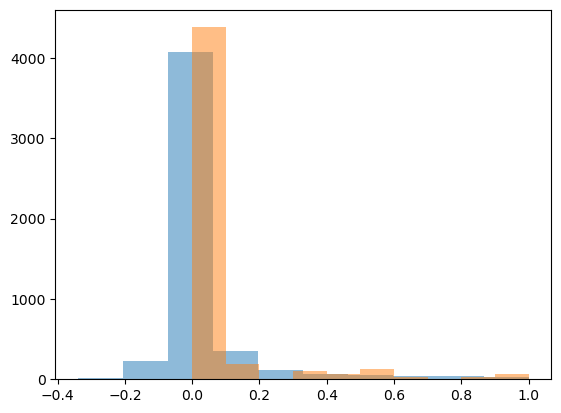

In [8]:
g = trainRegressor(K)
AcalPredict = g.predict(zCal)
Acal = np.array([1 - probsCal[i][y_cal[i]] for i in range(len(y_cal))])
Bcal = Acal - AcalPredict
plt.hist(Acal-AcalPredict, alpha=.5)
plt.hist(Acal, alpha=.5)
alpha = .01
QB = np.sort(Bcal)[int(np.ceil((len(Bcal) + 1) * (1 - alpha)))]
QA = np.sort(Acal)[int(np.ceil((len(Acal) + 1) * (1 - alpha)))]
print("QA, QB", QA, QB)

### Prediction sets

Compute the prediction sets from $Q_A$ and $Q_B$ for all test samples.
Let $n$ be
1. a True Positive if $y \in C_n$ and $y = y_n$,,
2. a False Positive if $y \in C_n$ but $y \neq y_n$,
3. a True Negative if $y \notin C_n$ and $y \neq y_n$, and
4. a False Negative if $y \notin C_n$ but $y \neq y_n$.

Compute the number of TP, FP, TN, and FN for $C_A$ and $C_B$ on all test samples.
Print the cases for which $|C_A| \neq |C_B|$. 

K, alpha, QA, QB, maxA, maxB 1 0.01 0.9 0.8 1.0 1.0
K, alpha, QA, QB, maxA, maxB 1 0.05 0.5 0.30000000000000004 1.0 1.0
K, alpha, QA, QB, maxA, maxB 1 0.09 0.19999999999999996 0.09999999999999998 1.0 1.0
K, alpha, QA, QB, maxA, maxB 1 0.13 0.09999999999999998 0.09999999999999998 1.0 1.0
K, alpha, QA, QB, maxA, maxB 1 0.17 0.09999999999999998 0.0 1.0 1.0
K, alpha, QA, QB, maxA, maxB 16 0.01 0.9 0.7937500000000001 1.0 1.0
K, alpha, QA, QB, maxA, maxB 16 0.05 0.5 0.3125 1.0 1.0
K, alpha, QA, QB, maxA, maxB 16 0.09 0.19999999999999996 0.13749999999999996 1.0 1.0
K, alpha, QA, QB, maxA, maxB 16 0.13 0.09999999999999998 0.07499999999999996 1.0 1.0
K, alpha, QA, QB, maxA, maxB 16 0.17 0.09999999999999998 0.012499999999999983 1.0 1.0
K, alpha, QA, QB, maxA, maxB 32 0.01 0.9 0.7937500000000001 1.0 1.0
K, alpha, QA, QB, maxA, maxB 32 0.05 0.5 0.33125000000000004 1.0 1.0
K, alpha, QA, QB, maxA, maxB 32 0.09 0.19999999999999996 0.14062500000000006 1.0 1.0
K, alpha, QA, QB, maxA, maxB 32 0.13 0.099

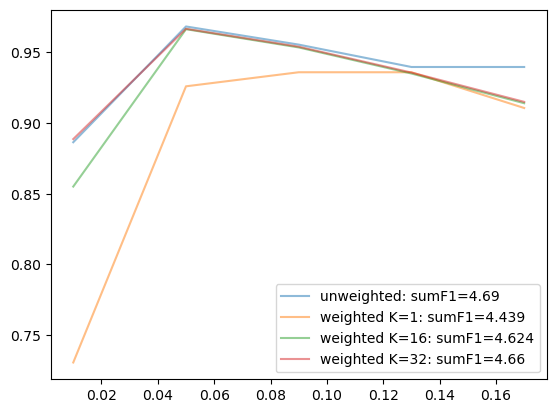

In [11]:
tryAlpha = [0.01 + 0.04 * i for i in range(5)]

for K in [1, 16, 32]:
    g = trainRegressor(K)
    AcalPredict = g.predict(zCal)
    Acal = np.array([1 - probsCal[i][y_cal[i]] for i in range(len(y_cal))])
    Bcal = Acal - AcalPredict
    auc = [], []
    
    for alpha in tryAlpha:#, 0.16, 0.32, 0.64, 0.9]:
        QB = np.sort(Bcal)[int(np.ceil((len(Bcal) + 1) * (1 - alpha)))-1]
        QA = np.sort(Acal)[int(np.ceil((len(Acal) + 1) * (1 - alpha)))-1]
        print("K, alpha, QA, QB, maxA, maxB", K, alpha, QA, QB, max(Acal), max(Bcal))
        AtestPredict = g.predict(zTest)
        Atest = np.array([[1 - probsTest[i][j] for j in range(len(probsTest[i]))] for i in range(len(probsTest))])
        Btest = np.array([[1 - probsTest[i][j] - AtestPredict[i] for j in range(len(probsTest[i]))] for i in range(len(probsTest))]) 
        intervalsA = [[j for j in range(len(probsTest[i])) if Atest[i][j] <= QA] for i in range(len(probsTest))]
        intervalsB = [[j for j in range(len(probsTest[i])) if Btest[i][j] <= QB] for i in range(len(probsTest))]

        TP, FP, TN, FN = [0, 0], [0, 0],[0, 0], [0, 0]
        intervalsAll = intervalsA, intervalsB
        for iModel in [0, 1]:
            for i in range(len(intervalsA)):
                intervals = intervalsAll[iModel][i]
                y = y_test[i]
                positives = [j for j in range(10) if j in intervals]
                TP[iModel] = TP[iModel] + sum([1 for j in positives if j == y])
                FP[iModel] = FP[iModel] + sum([1 for j in positives if j != y])
                negatives = [j for j in range(10) if j not in intervals]
                TN[iModel] = TN[iModel] + sum([1 for j in negatives if j != y])  
                FN[iModel] = FN[iModel] + sum([1 for j in negatives if j == y]) 
            F1 = 2 * TP[iModel]/(2 * TP[iModel] + FP[iModel] + FN[iModel])
            auc[iModel].append(F1)
    s = [np.round(sum([x for x in auc[iModel]]), 3) for iModel in [0, 1]]
    if (K==1): 
        plt.plot(tryAlpha, [x for x in auc[0]], label='unweighted: sumF1='+str(s[0]),alpha=0.5)
    plt.plot(tryAlpha, [x for x in auc[1]], label='weighted K='+str(K)+': sumF1='+str(s[1]) ,alpha=0.5)
plt.legend()
plt.show()
